In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import warnings
import time
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score
import xgboost as xgb
import lightgbm as lgb
#from imblearn import SMOTE

In [2]:
warnings.filterwarnings('ignore')
random_seed = 2021

In [3]:
raw_features = pd.read_csv("./data/features.csv")
raw_labels = pd.read_csv("./data/labels.csv")
raw_test = pd.read_csv("./data/test.csv")

In [4]:
raw_train = raw_features.merge(raw_labels, on='trackID', how='left')

## 1. Explorative Data Analysis

#### 1.1 Check Missing Values and Duplicate Entries for Features and Labels

In [5]:
raw_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Columns: 157 entries, trackID to vect_148
dtypes: float64(154), int64(1), object(2)
memory usage: 9.7+ MB


In [6]:
raw_features.head()

,trackID,title,tags,loudness,tempo,time_signature,key,mode,duration,vect_1,...,vect_139,vect_140,vect_141,vect_142,vect_143,vect_144,vect_145,vect_146,vect_147,vect_148
0,6654,Beside the Yellow Line,"i, the, to, and, a, me, it, not, in, my, is, o...",-8.539,104.341,3.0,7.0,1.0,298.73587,44.462048,...,0.000308,0.000302,0.000302,0.000315,0.000297,0.000305,0.000266,0.000225,0.130826,1.071914
1,5883,Ooh Na Na,"i, you, to, and, a, me, it, not, in, my, is, y...",-4.326,141.969,3.0,6.0,0.0,236.09424,46.069761,...,0.001751,0.001855,0.001920,0.001950,0.001937,0.001912,0.001836,0.001740,0.148765,0.882304
2,3424,Calabria 2008,"i, the, you, to, and, a, me, it, not, in, of, ...",-9.637,126.003,4.0,10.0,0.0,412.94322,40.376622,...,0.000951,0.001039,0.001116,0.001166,0.001159,0.001110,0.001015,0.000895,0.116206,0.306846
3,5434,Verbal Abuse (Just an American Band),"i, you, to, and, a, me, it, not, my, is, your,...",-10.969,197.625,4.0,2.0,1.0,64.78322,45.598532,...,0.000233,0.000284,0.000313,0.000325,0.000324,0.000299,0.000273,0.000236,0.163738,1.247803
4,516,Helen Of Troy,"i, the, to, a, me, it, not, in, is, your, we, ...",-5.369,170.008,4.0,0.0,1.0,191.97342,47.159148,...,0.000853,0.000927,0.000994,0.001037,0.001051,0.001011,0.000962,0.000898,0.108193,0.366419


In [7]:
non_vect_features = [cols for cols in raw_features.columns if "vect" not in cols and cols not in ['trackID', 'title']]
vect_features = [cols for cols in raw_features.columns if "vect" in cols]

raw_features.loc[:,non_vect_features].head()

,tags,loudness,tempo,time_signature,key,mode,duration
0,"i, the, to, and, a, me, it, not, in, my, is, o...",-8.539,104.341,3.0,7.0,1.0,298.73587
1,"i, you, to, and, a, me, it, not, in, my, is, y...",-4.326,141.969,3.0,6.0,0.0,236.09424
2,"i, the, you, to, and, a, me, it, not, in, of, ...",-9.637,126.003,4.0,10.0,0.0,412.94322
3,"i, you, to, and, a, me, it, not, my, is, your,...",-10.969,197.625,4.0,2.0,1.0,64.78322
4,"i, the, to, a, me, it, not, in, is, your, we, ...",-5.369,170.008,4.0,0.0,1.0,191.97342


In [8]:
raw_features.loc[:,non_vect_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tags            8116 non-null   object 
 1   loudness        8118 non-null   float64
 2   tempo           8117 non-null   float64
 3   time_signature  8119 non-null   float64
 4   key             8113 non-null   float64
 5   mode            8119 non-null   float64
 6   duration        8119 non-null   float64
dtypes: float64(6), object(1)
memory usage: 444.6+ KB


In [242]:
#### Check duplicate records in features table
print('Duplicate records for train features table is {}'.format(raw_features.duplicated().sum()))
print('Duplicate records for train labels table is {}'.format(raw_labels.duplicated().sum()))


Duplicate records for train features table is 0
Duplicate records for train labels table is 0


In [12]:
#### Check missing values for columns not starting with 'vect_'
pd.DataFrame(raw_features.shape[0] - raw_features.loc[:,non_vect_features].count(), columns=["missing_count"])\
  .sort_values('missing_count', ascending=False)

,missing_count
key,15
tags,12
tempo,11
loudness,10
time_signature,9
mode,9
duration,9


In [80]:
#### Check missing values for columns starting with 'vect_'
vect_missing = pd.DataFrame(raw_features.shape[0] - raw_features.loc[:,vect_features].count(), columns=['missing_count'])
vect_missing.loc[vect_missing.missing_count>0].sort_values("missing_count", ascending=False)

,missing_count
vect_12,13
vect_4,12
vect_6,12
vect_3,11
vect_1,10
...,...
vect_116,1
vect_41,1
vect_118,1
vect_51,1


In [81]:
#### Check possible missing genre labels
print("Number of missing genre labels is {}".format(raw_train.genre.isnull().sum()))

Number of missing genre labels is 0


#### 1.2 Exploration on Features' Patterns within Each Genre Class

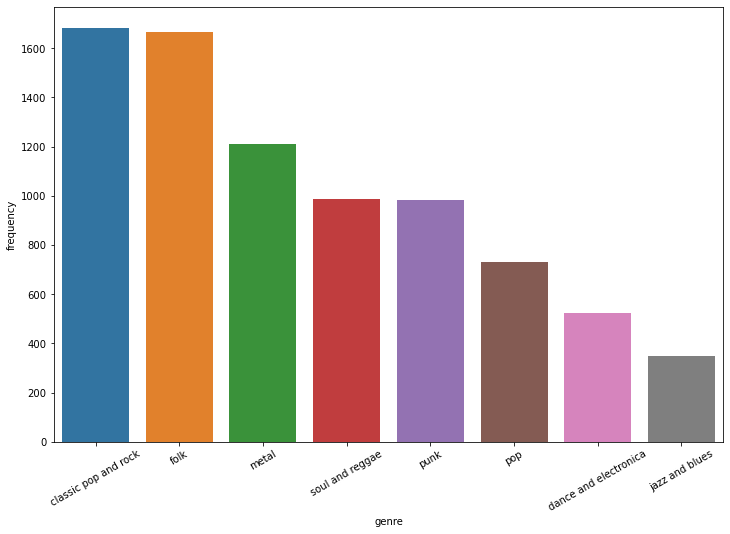

In [82]:
#### Check genre label disttribution
genre_counts = pd.DataFrame(raw_train.genre.value_counts()).reset_index()
genre_counts.columns = ['genre','frequency']

plt.figure(figsize=(12,8))
sns.barplot(x='genre', y='frequency', data=genre_counts)
plt.xticks(rotation = '30')
plt.show()

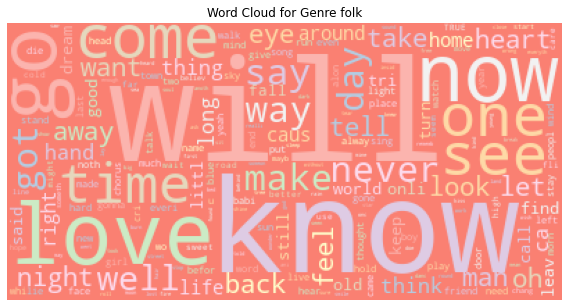

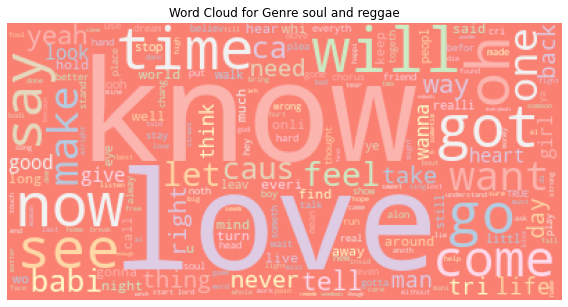

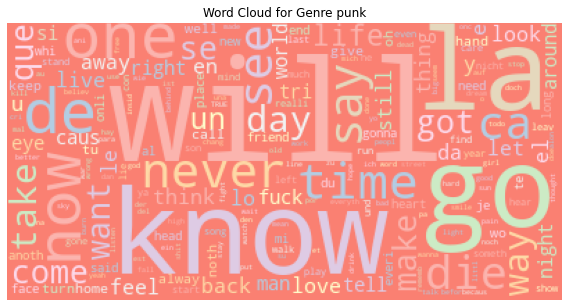

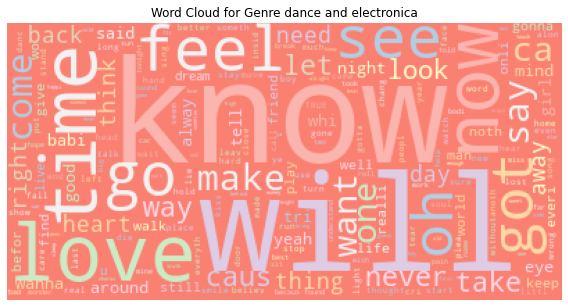

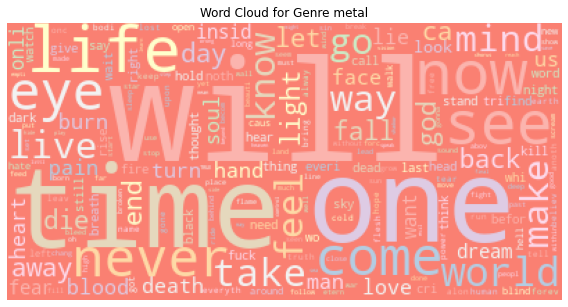

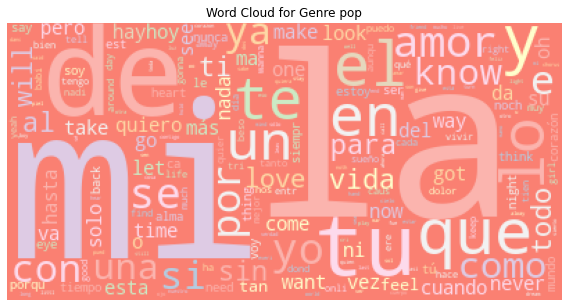

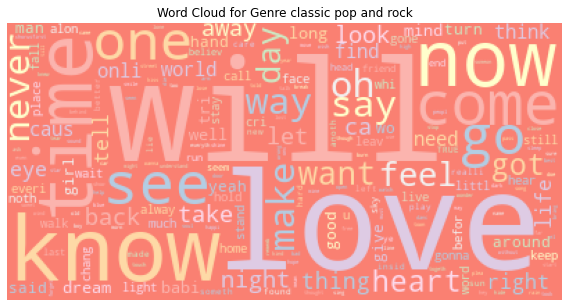

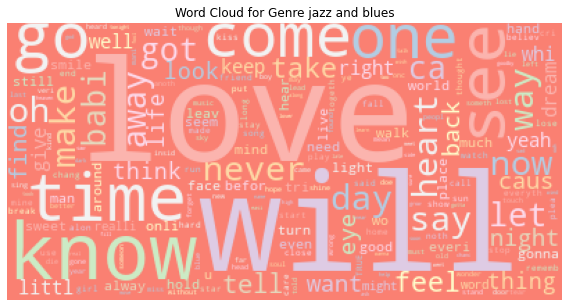

In [83]:
#### 'tags' pattern
for t_genre in raw_train.genre.unique():
    t_df = raw_train.loc[raw_train.genre == t_genre, 'tags'].dropna()
    tags_corpus = ",".join(t_df)
    tags_cloud = WordCloud(random_state=1, background_color='salmon', colormap='Pastel1',
                           collocations=False, stopwords=STOPWORDS).generate(tags_corpus)
    
    plt.figure(figsize = (8,6))
    plt.axis('off')
    plt.title('Word Cloud for Genre {}'.format(t_genre))
    plt.tight_layout()
    plt.imshow(tags_cloud)    
    

In [14]:
#### examine top 5 frequent tags for genre 'pop'
tags_corpus = ",".join(raw_train.loc[raw_train.genre == 'pop', 'tags'].dropna())
tags_corpus = tags_corpus.replace(" ","").split(",")
tags_corpus = pd.DataFrame([words for words in tags_corpus if words not in STOPWORDS])
pd.DataFrame(tags_corpus.value_counts(), columns=['count']).sort_values('count', ascending=False).head(5)

,count
0,
de,389
que,363
y,346
el,320
la,310


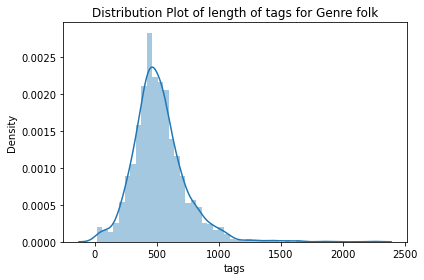

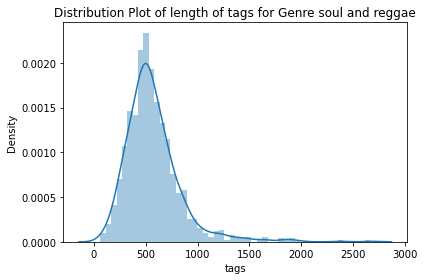

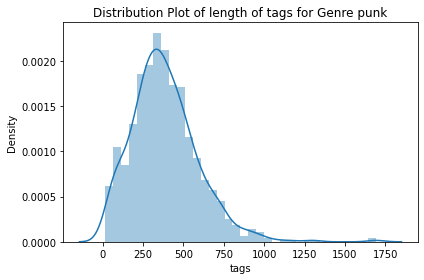

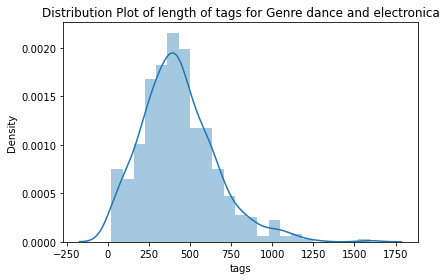

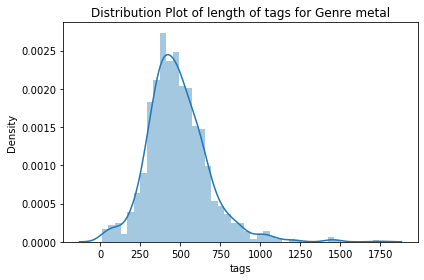

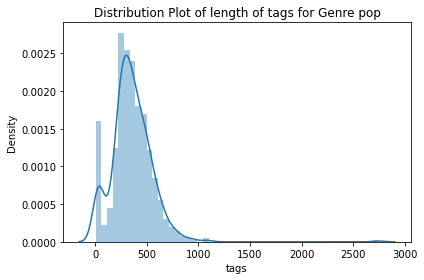

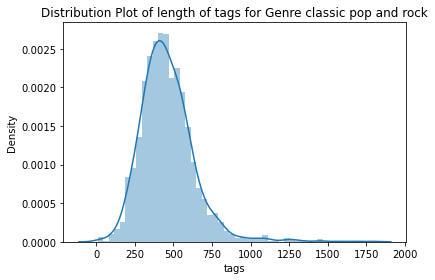

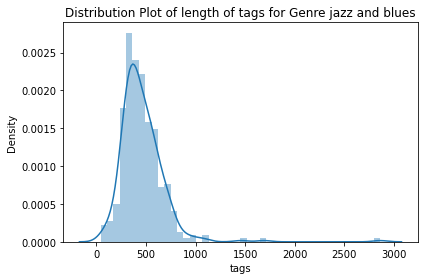

In [148]:
#### length of 'tags' pattern
for t_genre in raw_train.genre.unique():
    t_df = raw_train.loc[raw_train.genre == t_genre, 'tags'].dropna().apply(lambda x: len(x))

    plt.figure(figsize = (6,4))
    #plt.axis('off')
    plt.title('Distribution Plot of length of tags for Genre {}'.format(t_genre))
    sns.distplot(t_df)
    plt.tight_layout()
    plt.show()


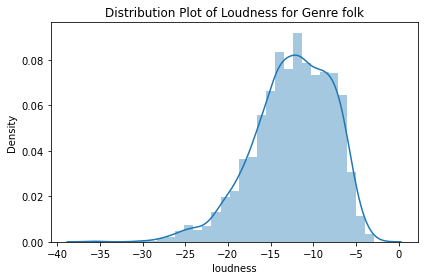

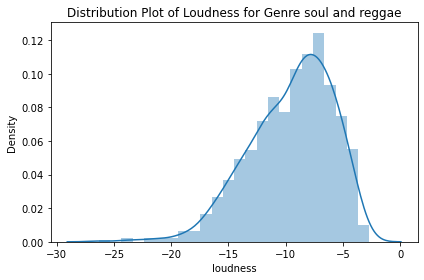

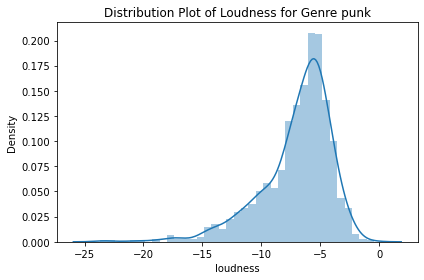

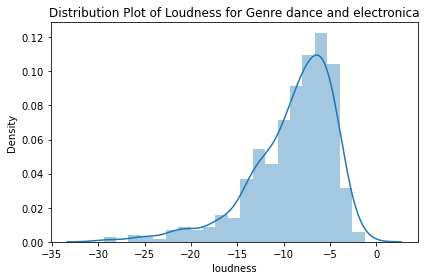

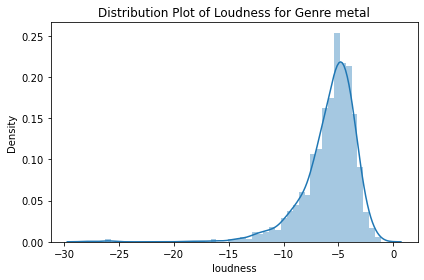

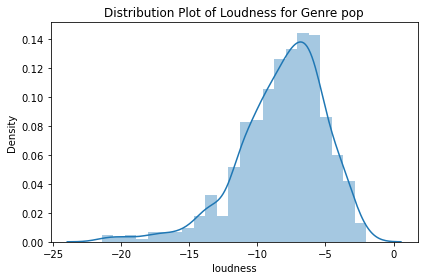

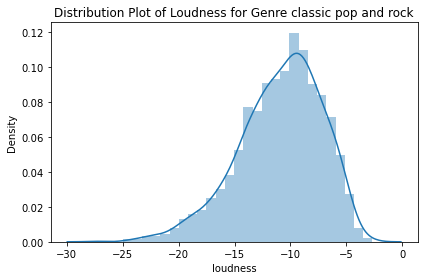

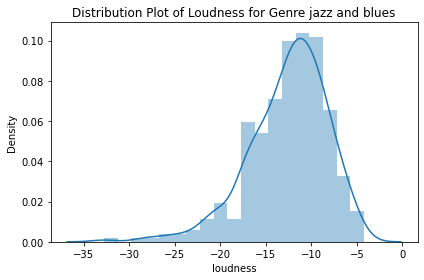

In [155]:
#### 'loudness' pattern
for t_genre in raw_train.genre.unique():
    t_df = raw_train.loc[raw_train.genre == t_genre, 'loudness'].dropna()

    plt.figure(figsize = (6,4))
    #plt.axis('off')
    plt.title('Distribution Plot of Loudness for Genre {}'.format(t_genre))
    sns.distplot(t_df)
    plt.tight_layout()
    plt.show()


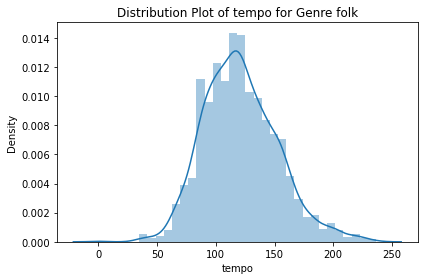

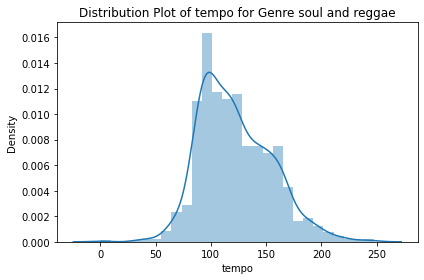

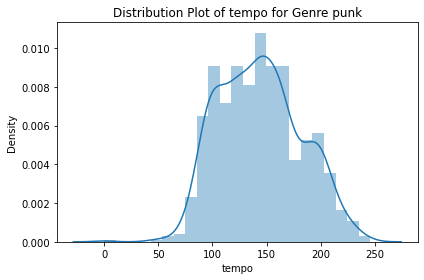

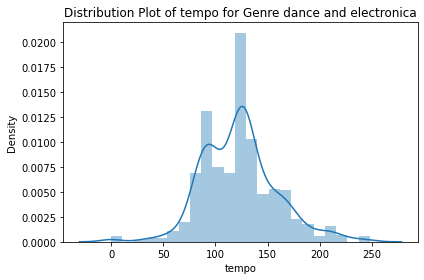

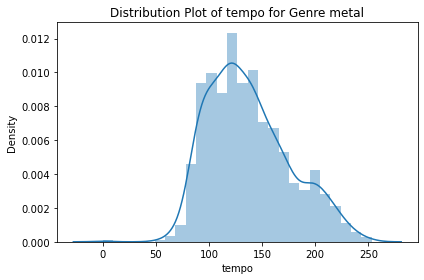

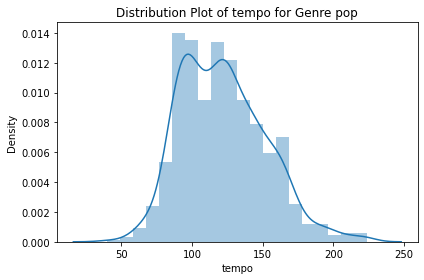

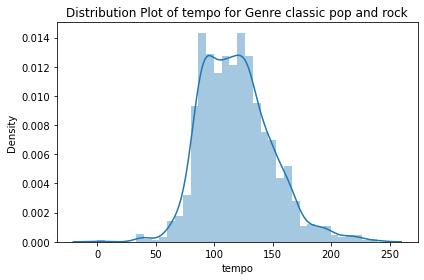

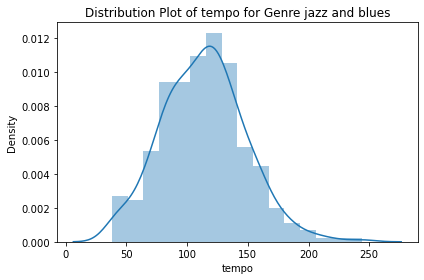

In [156]:
#### 'tempo' pattern
for t_genre in raw_train.genre.unique():
    t_df = raw_train.loc[raw_train.genre == t_genre, 'tempo'].dropna()

    plt.figure(figsize = (6,4))
    #plt.axis('off')
    plt.title('Distribution Plot of tempo for Genre {}'.format(t_genre))
    sns.distplot(t_df)
    plt.tight_layout()
    plt.show()


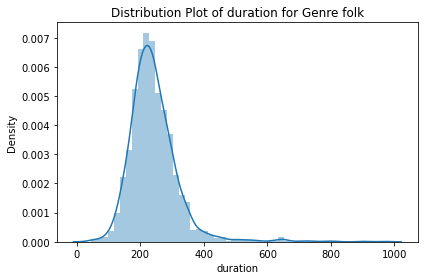

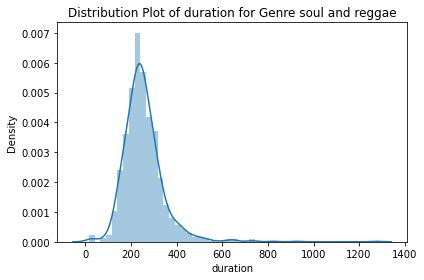

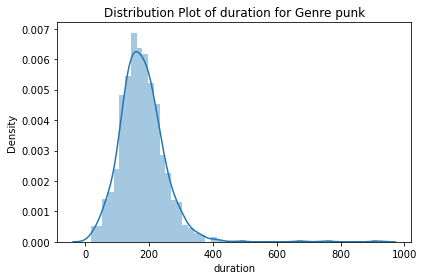

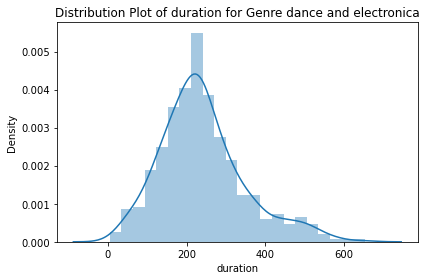

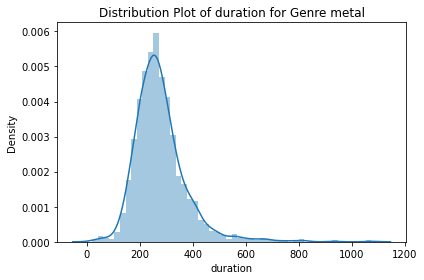

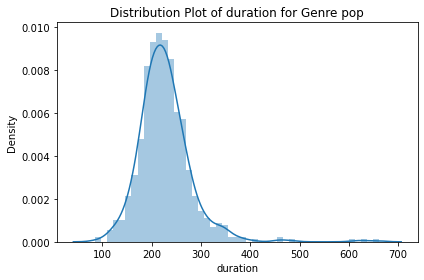

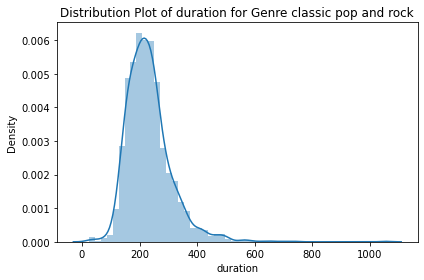

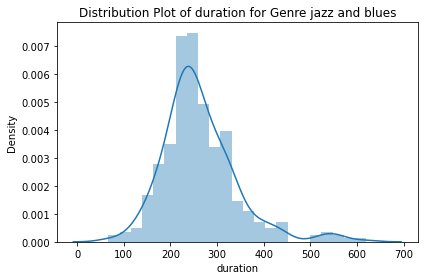

In [157]:
#### 'duration' pattern
for t_genre in raw_train.genre.unique():
    t_df = raw_train.loc[raw_train.genre == t_genre, 'duration'].dropna()

    plt.figure(figsize = (6,4))
    #plt.axis('off')
    plt.title('Distribution Plot of duration for Genre {}'.format(t_genre))
    sns.distplot(t_df)
    plt.tight_layout()
    plt.show()


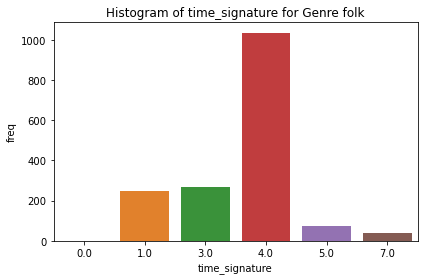

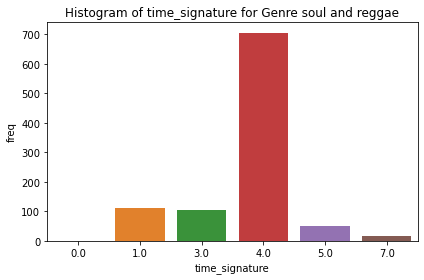

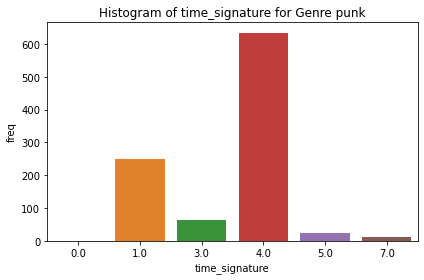

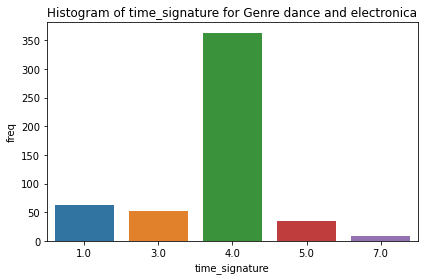

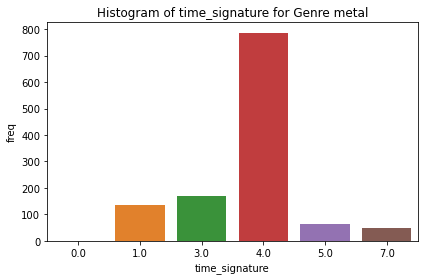

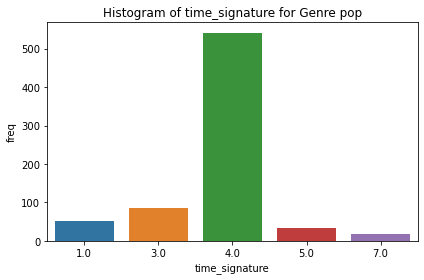

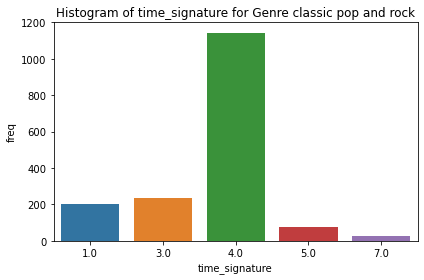

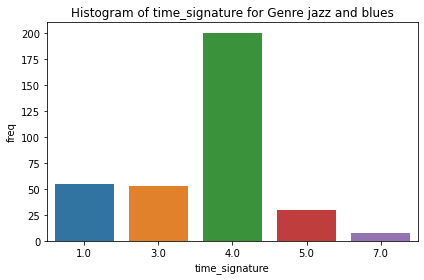

In [170]:
#### 'time_signature' pattern
for t_genre in raw_train.genre.unique():
    t_df = raw_train.loc[raw_train.genre == t_genre, 'time_signature'].dropna()
    t_df = pd.DataFrame(t_df.astype(str))
    t_df = pd.DataFrame(t_df.value_counts(), columns=['freq']).reset_index().sort_values('time_signature')

    plt.figure(figsize = (6,4))
    #plt.axis('off')
    plt.title('Histogram of time_signature for Genre {}'.format(t_genre))
    sns.barplot(x='time_signature', y='freq', data=t_df)
    plt.tight_layout()
    plt.show()


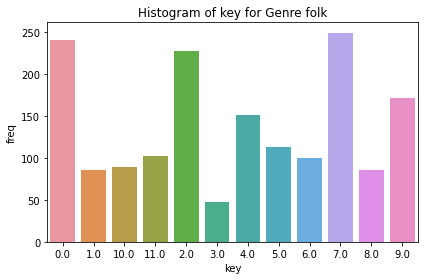

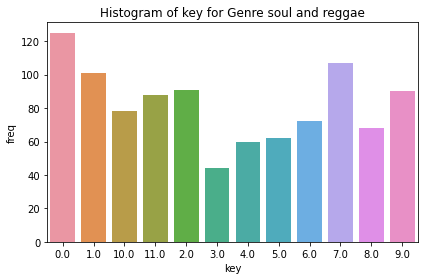

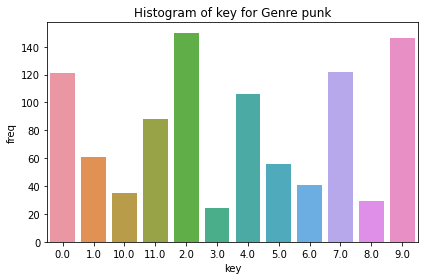

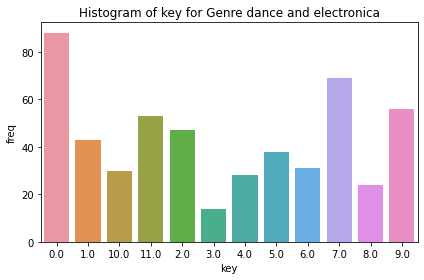

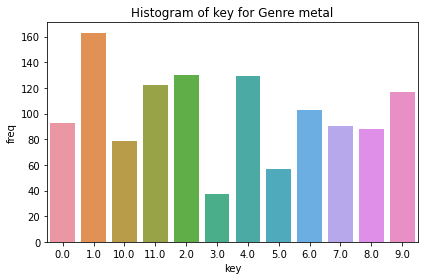

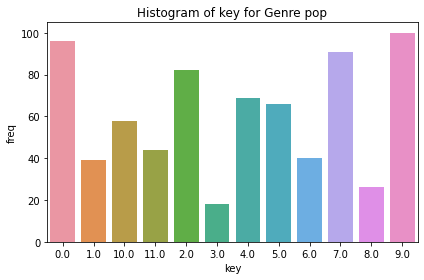

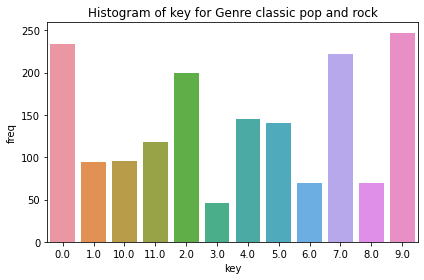

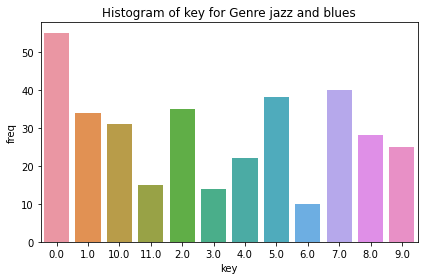

In [171]:
#### 'key' pattern
for t_genre in raw_train.genre.unique():
    t_df = raw_train.loc[raw_train.genre == t_genre, 'key'].dropna()
    t_df = pd.DataFrame(t_df.astype(str))
    t_df = pd.DataFrame(t_df.value_counts(), columns=['freq']).reset_index().sort_values('key')

    plt.figure(figsize = (6,4))
    #plt.axis('off')
    plt.title('Histogram of key for Genre {}'.format(t_genre))
    sns.barplot(x='key', y='freq', data=t_df)
    plt.tight_layout()
    plt.show()


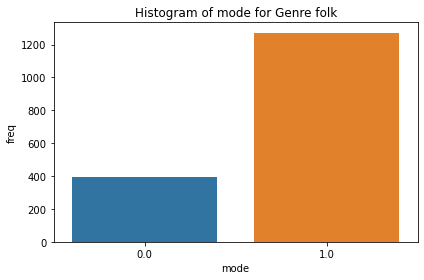

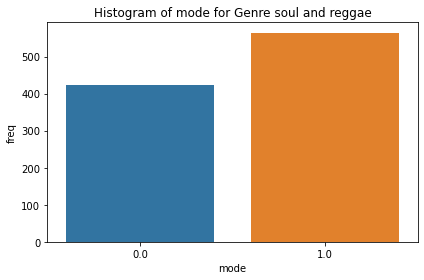

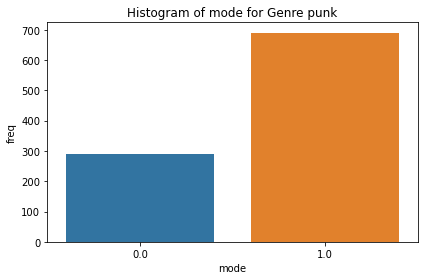

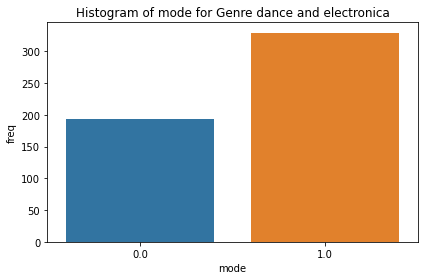

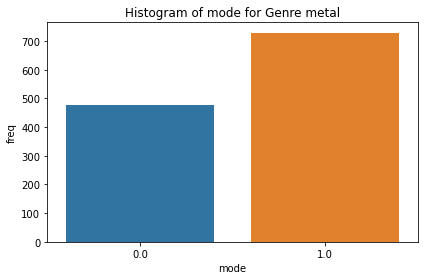

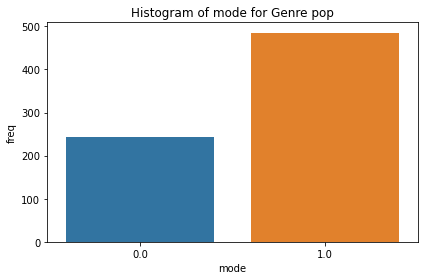

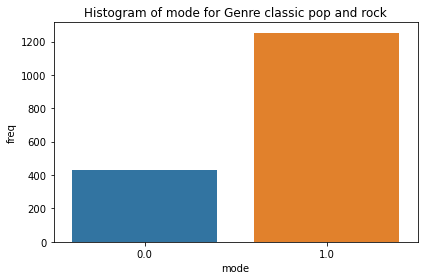

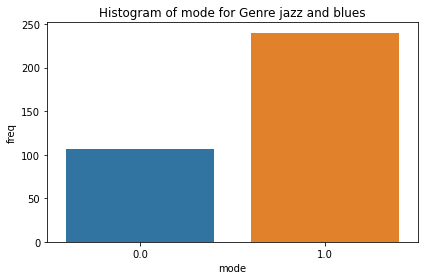

In [172]:
#### 'mode' pattern
for t_genre in raw_train.genre.unique():
    t_df = raw_train.loc[raw_train.genre == t_genre, 'mode'].dropna()
    t_df = pd.DataFrame(t_df.astype(str))
    t_df = pd.DataFrame(t_df.value_counts(), columns=['freq']).reset_index().sort_values('mode')

    plt.figure(figsize = (6,4))
    #plt.axis('off')
    plt.title('Histogram of mode for Genre {}'.format(t_genre))
    sns.barplot(x='mode', y='freq', data=t_df)
    plt.tight_layout()
    plt.show()


## 2. Data Preprocessing

#### 2.1 Remove NAs in all features via listwise deletion

In [77]:
df_train = raw_train.copy().dropna(subset=non_vect_features + vect_features, axis=0, how='any')

#### 2.2 Convert some numerical features to categorical features

In [78]:
# Convert 'mode', 'key', 'time_signature' to categorical features
df_train['mode'] = df_train['mode'].astype(str)
df_train['key'] = df_train['key'].astype(str)
df_train['time_signature'] = df_train['time_signature'].astype(str)

## 3. Feature Engineering

#### 3.1 Create dummy variable to count presence of top 5 frequent tags of 'pop' genre for each data record

In [79]:
tags_corpus = ",".join(df_train.loc[df_train.genre == 'pop', 'tags'].dropna())
tags_corpus = tags_corpus.replace(" ","").split(",")
tags_corpus = pd.DataFrame([words for words in tags_corpus if words not in STOPWORDS])
top_tags = pd.DataFrame(tags_corpus.value_counts(), columns=['count']).sort_values('count', ascending=False).head(5)\
             .reset_index()
top_tags.columns = ['tags','count']
top_tags

,tags,count
0,de,365
1,que,340
2,y,324
3,el,302
4,la,295


In [80]:
df_train['pop_tags'] = 0
df_train['pop_tags'] = df_train['pop_tags'] + df_train.tags.apply(lambda x: np.where(top_tags.tags[0] in x.replace(" ","").split(","),1,0))
df_train['pop_tags'] = df_train['pop_tags'] + df_train.tags.apply(lambda x: np.where(top_tags.tags[1] in x.replace(" ","").split(","),1,0))
df_train['pop_tags'] = df_train['pop_tags'] + df_train.tags.apply(lambda x: np.where(top_tags.tags[2] in x.replace(" ","").split(","),1,0))
df_train['pop_tags'] = df_train['pop_tags'] + df_train.tags.apply(lambda x: np.where(top_tags.tags[3] in x.replace(" ","").split(","),1,0))
df_train['pop_tags'] = df_train['pop_tags'] + df_train.tags.apply(lambda x: np.where(top_tags.tags[4] in x.replace(" ","").split(","),1,0))

#### 3.2 Normalization - split train and validation sets first to avoid data leakage

In [81]:
feature_cols = [x for x in df_train.columns if x not in ['trackID', 'title', 'genre', 'tags']]
target_col = ['genre']

features_all = df_train[feature_cols]
target_all = df_train[target_col]

In [82]:
X_train, X_val, y_train, y_val = train_test_split(features_all, target_all, test_size = 0.1, stratify=target_all.genre,
                                                  random_state = random_seed)

#### 3.3 Normalization - scale numeric features through MinMax

In [83]:
#### Normalize numeric features through MinMax to convert raw values into range 0-1
numeric_features = [x for x in feature_cols if x not in ['time_signature','key','mode']]
mm_scaler = MinMaxScaler()
col_transform = ColumnTransformer(transformers=[('minmax', mm_scaler, numeric_features)], remainder='passthrough')
col_transform.fit(X_train[numeric_features])

scaled_feature_names = ['scaled_'+x for x in numeric_features]
scaled_vect_names = [x for x in scaled_feature_names if 'vect_' in x]
scaled_features_train = col_transform.transform(X_train[numeric_features])
scaled_features_val = col_transform.transform(X_val[numeric_features])
scaled_features_train = pd.DataFrame(scaled_features_train, columns=scaled_feature_names)
scaled_features_val = pd.DataFrame(scaled_features_val, columns=scaled_feature_names)

X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_train.drop(numeric_features, axis=1, inplace=True)
X_val.drop(numeric_features, axis=1, inplace=True)

X_train = pd.concat([X_train, scaled_features_train], axis=1)
X_val = pd.concat([X_val, scaled_features_val], axis=1)

X_train_noPCA = X_train.copy()
X_val_noPCA = X_val.copy()

#### 3.4 Principal Components Analysis for dimension reduction of 'vect_' features

In [84]:
#### Apply PCA to scaled 'vect_' features
pca = PCA(n_components = 0.95)
pca.fit(X_train[scaled_vect_names])
pcs_train = pca.transform(X_train[scaled_vect_names])
print('Number of Principal Components reduced to is {}'.format(pcs_train.shape[1]))
pcs_train = pd.DataFrame(pcs_train, columns=['PC_'+ str(x) for x in list(range(pcs_train.shape[1]))])

pcs_val = pca.transform(X_val[scaled_vect_names])
pcs_val= pd.DataFrame(pcs_val, columns=['PC_'+ str(x) for x in list(range(pcs_val.shape[1]))])

X_train.drop(scaled_vect_names, axis=1, inplace=True)
X_val.drop(scaled_vect_names, axis=1, inplace=True)
X_train = pd.concat([X_train, pcs_train], axis=1)
X_val = pd.concat([X_val, pcs_val], axis=1)

Number of Principal Components reduced to is 40


#### 3.5 One-hot encoding categorical features

In [85]:
#### One-hot encode 'time_signature'
time_sig_encoder = OneHotEncoder(handle_unknown='ignore')
time_sig_encoder.fit(np.array(X_train.time_signature).reshape(-1,1))
time_sig_names = [ 'time_signature_'+x for x in np.sort(X_train.time_signature.unique())] 

encoded_time_train = time_sig_encoder.transform(np.array(X_train.time_signature).reshape(-1,1)).toarray()
encoded_time_train = pd.DataFrame(encoded_time_train, columns=time_sig_names)
encoded_time_val = time_sig_encoder.transform(np.array(X_val.time_signature).reshape(-1,1)).toarray()
encoded_time_val = pd.DataFrame(encoded_time_val, columns=time_sig_names)

In [86]:
#### One-hot encode 'key'
key_encoder = OneHotEncoder(handle_unknown='ignore')
key_encoder.fit(np.array(X_train.key).reshape(-1,1))
key_names = [ 'key_'+x for x in np.sort(X_train.key.unique())] 

encoded_key_train = key_encoder.transform(np.array(X_train.key).reshape(-1,1)).toarray()
encoded_key_train = pd.DataFrame(encoded_key_train, columns=key_names)
encoded_key_val = key_encoder.transform(np.array(X_val.key).reshape(-1,1)).toarray()
encoded_key_val = pd.DataFrame(encoded_key_val, columns=key_names)

In [87]:
#### One-hot encode 'mode'
mode_encoder = OneHotEncoder(handle_unknown='ignore')
mode_encoder.fit(np.array(X_train['mode']).reshape(-1,1))
mode_names = [ 'mode_'+x for x in np.sort(X_train['mode'].unique())] 

encoded_mode_train = mode_encoder.transform(np.array(X_train['mode']).reshape(-1,1)).toarray()
encoded_mode_train = pd.DataFrame(encoded_mode_train, columns=mode_names)
encoded_mode_val = mode_encoder.transform(np.array(X_val['mode']).reshape(-1,1)).toarray()
encoded_mode_val = pd.DataFrame(encoded_mode_val, columns=mode_names)

In [88]:
#### Incorporate One-hot encoded variables
# feature space with PCA
X_train.drop(['time_signature','key','mode'], axis=1, inplace=True)
X_val.drop(['time_signature','key','mode'], axis=1, inplace=True)
X_train = pd.concat([X_train,encoded_time_train],axis=1)
X_train = pd.concat([X_train,encoded_key_train],axis=1)
X_train = pd.concat([X_train,encoded_mode_train],axis=1)
X_val = pd.concat([X_val,encoded_time_val],axis=1)
X_val = pd.concat([X_val,encoded_key_val],axis=1)
X_val = pd.concat([X_val,encoded_mode_val],axis=1)


# feature space without PCA
X_train_noPCA.drop(['time_signature','key','mode'], axis=1, inplace=True)
X_val_noPCA.drop(['time_signature','key','mode'], axis=1, inplace=True)
X_train_noPCA = pd.concat([X_train_noPCA,encoded_time_train],axis=1)
X_train_noPCA = pd.concat([X_train_noPCA,encoded_key_train],axis=1)
X_train_noPCA = pd.concat([X_train_noPCA,encoded_mode_train],axis=1)
X_val_noPCA = pd.concat([X_val_noPCA,encoded_time_val],axis=1)
X_val_noPCA = pd.concat([X_val_noPCA,encoded_key_val],axis=1)
X_val_noPCA = pd.concat([X_val_noPCA,encoded_mode_val],axis=1)

#### 3.6 Test effectiveness of PCA using simple ML models

In [95]:
#### Test performance of PCA feature space vs non-PCA feature space with simple ML model
# No PCA: LGB
basic_lgb_ori = lgb.LGBMClassifier(n_jobs=2, random_state=random_seed)
basic_lgb_ori.fit(X_train_noPCA, y_train)
basic_val_preds =  basic_lgb_ori.predict(X_val_noPCA)
print(classification_report(y_val.genre, basic_val_preds))

                       precision    recall  f1-score   support

 classic pop and rock       0.58      0.71      0.64       161
dance and electronica       0.75      0.43      0.55        49
                 folk       0.64      0.76      0.70       159
       jazz and blues       0.83      0.29      0.43        34
                metal       0.82      0.82      0.82       114
                  pop       0.80      0.62      0.70        69
                 punk       0.73      0.67      0.70        94
      soul and reggae       0.66      0.68      0.67        94

             accuracy                           0.68       774
            macro avg       0.73      0.62      0.65       774
         weighted avg       0.70      0.68      0.68       774



In [91]:
# PCA: LGB
basic_lgb = lgb.LGBMClassifier(n_jobs=2, random_state=random_seed)
basic_lgb.fit(X_train, y_train)
basic_val_preds = basic_lgb.predict(X_val)
print(classification_report(y_val.genre, basic_val_preds))

                       precision    recall  f1-score   support

 classic pop and rock       0.52      0.66      0.58       161
dance and electronica       0.62      0.37      0.46        49
                 folk       0.61      0.70      0.65       159
       jazz and blues       0.53      0.24      0.33        34
                metal       0.83      0.80      0.81       114
                  pop       0.83      0.64      0.72        69
                 punk       0.76      0.63      0.69        94
      soul and reggae       0.60      0.64      0.62        94

             accuracy                           0.64       774
            macro avg       0.66      0.58      0.61       774
         weighted avg       0.66      0.64      0.64       774



In [92]:
# No PCA: RF
basic_rf = RandomForestClassifier(n_jobs=2, random_state=random_seed)
basic_rf.fit(X_train_noPCA, y_train)
basic_rf_preds =  basic_rf.predict(X_val_noPCA)
print(classification_report(y_val.genre, basic_rf_preds))

                       precision    recall  f1-score   support

 classic pop and rock       0.52      0.63      0.57       161
dance and electronica       0.87      0.27      0.41        49
                 folk       0.57      0.75      0.64       159
       jazz and blues       1.00      0.06      0.11        34
                metal       0.79      0.81      0.80       114
                  pop       0.75      0.59      0.66        69
                 punk       0.72      0.62      0.67        94
      soul and reggae       0.59      0.62      0.60        94

             accuracy                           0.63       774
            macro avg       0.72      0.54      0.56       774
         weighted avg       0.66      0.63      0.61       774



In [93]:
# PCA: RF
basic_rf = RandomForestClassifier(n_jobs=2, random_state=random_seed)
basic_rf.fit(X_train, y_train)
basic_rf_preds =  basic_rf.predict(X_val)
print(classification_report(y_val.genre, basic_rf_preds))

                       precision    recall  f1-score   support

 classic pop and rock       0.52      0.68      0.59       161
dance and electronica       0.87      0.27      0.41        49
                 folk       0.60      0.77      0.67       159
       jazz and blues       0.00      0.00      0.00        34
                metal       0.76      0.84      0.80       114
                  pop       0.82      0.58      0.68        69
                 punk       0.77      0.57      0.66        94
      soul and reggae       0.59      0.61      0.60        94

             accuracy                           0.64       774
            macro avg       0.62      0.54      0.55       774
         weighted avg       0.64      0.64      0.62       774



Conclusion: PCA seemed not to improve model performance, hence it will not be applied

#### 3.7 Naive forward selection of features

In [97]:
#### Feature importance
basic_feature_scores = pd.DataFrame({'feature_name':X_train_noPCA.columns,
                                     'importance_score':basic_lgb_ori.feature_importances_})\
                         .sort_values('importance_score',ascending=False)

In [148]:
features_subset=[]
best_macro_f1 = 0
best_accuracy = 0
optimal_subset = []

for t_feature in basic_feature_scores.feature_name:
    features_subset.append(t_feature)
    t_X_train = X_train_noPCA[features_subset]
    t_X_val = X_val_noPCA[features_subset]
    
    basic_lgb_ori.fit(t_X_train, y_train)
    t_val_preds = basic_lgb_ori.predict(t_X_val)
    t_f1_score = f1_score(y_val.genre, t_val_preds, average='macro')
    t_accuracy = accuracy_score(y_val.genre, t_val_preds)
    
    if (t_f1_score > best_macro_f1) and ((t_f1_score-best_macro_f1)/best_macro_f1 > 0.01):
        best_macro_f1 = t_f1_score
        best_accuracy = t_accuracy
        optimal_subset = features_subset.copy()

In [149]:
print(best_macro_f1)
print(best_accuracy)
len(optimal_subset)

0.6867221307422509
0.7157622739018088


115

In [150]:
optimal_subset

['scaled_duration',
 'scaled_vect_6',
 'scaled_vect_8',
 'scaled_vect_5',
 'scaled_vect_11',
 'scaled_vect_38',
 'scaled_vect_41',
 'scaled_vect_37',
 'scaled_vect_121',
 'scaled_pop_tags',
 'scaled_vect_10',
 'scaled_vect_7',
 'scaled_vect_35',
 'scaled_vect_36',
 'scaled_vect_14',
 'scaled_vect_39',
 'scaled_vect_34',
 'scaled_vect_15',
 'scaled_vect_13',
 'scaled_vect_19',
 'scaled_vect_2',
 'scaled_vect_12',
 'scaled_vect_4',
 'scaled_vect_122',
 'scaled_vect_28',
 'scaled_vect_33',
 'scaled_vect_9',
 'scaled_vect_24',
 'scaled_vect_30',
 'scaled_tempo',
 'scaled_vect_94',
 'scaled_vect_32',
 'scaled_vect_16',
 'scaled_vect_125',
 'scaled_loudness',
 'scaled_vect_3',
 'scaled_vect_17',
 'scaled_vect_61',
 'scaled_vect_40',
 'scaled_vect_134',
 'scaled_vect_1',
 'scaled_vect_31',
 'scaled_vect_118',
 'scaled_vect_20',
 'scaled_vect_23',
 'scaled_vect_128',
 'scaled_vect_21',
 'scaled_vect_99',
 'scaled_vect_124',
 'scaled_vect_22',
 'scaled_vect_103',
 'scaled_vect_102',
 'scaled_ve

Conclusion: features are selected based on this forward selection approach

In [153]:
X_train_noPCA = X_train_noPCA[optimal_subset]
X_val_noPCA = X_val_noPCA[optimal_subset]

X_train_noPCA.shape

(6957, 115)

## 4. Modelling, Tuning and Evaluation

#### 4.1 Set up hyperparameter grid for cross validation

In [154]:
xgb_params = {
    'max_depth':(3,10),
    'learning_rate': (0.05, 0.3),
    'n_estimators': (30, 800),
    'gamma': (0, 1),
    'colsample_bytree': (0.5, 1),
    'subsample': (0.5, 1),
    'min_child_weight': (1, 10)
}

lgb_params = {
    'max_depth':(3,10),
    'learning_rate': (0.05, 0.3),
    'n_estimators': (30, 800),
    'colsample_bytree': (0.5, 1),
    'subsample': (0.5, 1),
    'min_child_weight': (1, 10)
}

rf_params = {
    'max_depth':(3,10),
    'n_estimators': (50, 1000),
    'max_features': (0.2, 1),
    'min_samples_leaf': (1, 6)
}

lr_params = {
    'C':(0.001, 100),
    'penalty': ['l2', 'none']
    }


#### 4.2 Apply Bayesian Optimization and Cross Validation for Hyperparameter Tuning to select the best model

In [155]:
xgb_best = []
lgb_best = []
rf_best = []
lr_best = []

In [156]:
model_xgb = xgb.XGBClassifier(n_jobs=2, random_state=random_seed)
model_lgb = lgb.LGBMClassifier(n_jobs=2, random_state=random_seed)
model_rf = RandomForestClassifier(n_jobs=2, random_state=random_seed)
model_lr = LogisticRegression(n_jobs=2, solver='sag', random_state=random_seed)

start_time = time.time()
bs_xgb = BayesSearchCV(estimator=model_xgb, search_spaces=xgb_params, scoring='f1_macro', 
                       n_iter=40, cv=3, n_jobs=2, random_state=random_seed)
bs_xgb.fit(X_train_noPCA, y_train)
end_time = time.time()
dur = (end_time-start_time)/60
best_xgb = bs_xgb.best_estimator_
xgb_val_preds = best_xgb.predict(X_val_noPCA)
xgb_best.append(bs_xgb.best_params_)
print('Time taken for training is {:.2f} mins \n'.format(dur))
print(classification_report(y_val.genre, xgb_val_preds))
print('\n')


start_time = time.time()
bs_lgb = BayesSearchCV(model_lgb, lgb_params, scoring='f1_macro', n_iter=40, cv=3, n_jobs=2, random_state=random_seed)
bs_lgb.fit(X_train_noPCA, y_train)
end_time = time.time()
dur = (end_time-start_time)/60
best_lgb = bs_lgb.best_estimator_
lgb_val_preds = best_lgb.predict(X_val_noPCA)
lgb_best.append(bs_lgb.best_params_)
print('Time taken for training is {:.2f} mins \n'.format(dur))
print(classification_report(y_val.genre, lgb_val_preds))
print('\n')


start_time = time.time()
bs_rf = BayesSearchCV(model_rf, rf_params, scoring='f1_macro', n_iter=40, cv=3, n_jobs=2, random_state=random_seed)
bs_rf.fit(X_train_noPCA, y_train)
end_time = time.time()
dur = (end_time-start_time)/60
best_rf = bs_rf.best_estimator_
rf_val_preds = best_rf.predict(X_val_noPCA)
rf_best.append(bs_rf.best_params_)
print('Time taken for training is {:.2f} mins \n'.format(dur))
print(classification_report(y_val.genre, rf_val_preds))
print('\n')


start_time = time.time()
bs_lr = BayesSearchCV(model_lr, lr_params, scoring='f1_macro', n_iter=40, cv=3, n_jobs=2, random_state=random_seed)
bs_lr.fit(X_train_noPCA, y_train)
end_time = time.time()
dur = (end_time-start_time)/60
best_lr = bs_lr.best_estimator_
lr_val_preds = best_lr.predict(X_val_noPCA)
lr_best.append(bs_lr.best_params_)
print('Time taken for training is {:.2f} mins \n'.format(dur))
print(classification_report(y_val.genre, lr_val_preds))
print('\n')



[01:06:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time taken for training is 122.55 mins 

                       precision    recall  f1-score   support

 classic pop and rock       0.63      0.70      0.66       161
dance and electronica       0.68      0.55      0.61        49
                 folk       0.65      0.76      0.70       159
       jazz and blues       0.76      0.38      0.51        34
                metal       0.83      0.84      0.84       114
                  pop       0.76      0.68      0.72        69
                 punk       0.79      0.67      0.72        94
      soul and reggae       0.63      0.66      0.65        94

             accuracy                           0.70       774
            macr

AttributeError: 'str' object has no attribute 'decode'

In [158]:
xgb_best.append(best_xgb)
xgb_best.append(xgb_val_preds)
lgb_best.append(best_lgb)
lgb_best.append(lgb_val_preds)
rf_best.append(best_rf)
rf_best.append(rf_val_preds)

with open('xgb_best_save.p','wb') as fp1:
    pickle.dump(xgb_best, fp1, protocol=pickle.HIGHEST_PROTOCOL)
with open('lgb_best_save.p','wb') as fp2:
    pickle.dump(lgb_best, fp2, protocol=pickle.HIGHEST_PROTOCOL)
with open('rf_best_save.p','wb') as fp3:
    pickle.dump(rf_best, fp3, protocol=pickle.HIGHEST_PROTOCOL)   

In [164]:
#### Training for logistic-regression (error encountered in previous run due to sklearn version)
lr_params = {
    'C':(0.001, 100),
    'penalty': ['l2', 'none']
    }

model_lr = LogisticRegression(n_jobs=2, solver='newton-cg', random_state=random_seed) #solver='saga'

start_time = time.time()
bs_lr = BayesSearchCV(model_lr, lr_params, scoring='f1_macro', n_iter=40, cv=3, n_jobs=2, random_state=random_seed)
bs_lr.fit(X_train_noPCA, y_train)
end_time = time.time()
dur = (end_time-start_time)/60
best_lr = bs_lr.best_estimator_
lr_val_preds = best_lr.predict(X_val_noPCA)
lr_best.append(bs_lr.best_params_)
print('Time taken for training is {:.2f} mins \n'.format(dur))
print(classification_report(y_val.genre, lr_val_preds))
print('\n')

Time taken for training is 7.88 mins 

                       precision    recall  f1-score   support

 classic pop and rock       0.58      0.65      0.62       161
dance and electronica       0.53      0.35      0.42        49
                 folk       0.60      0.69      0.64       159
       jazz and blues       0.39      0.26      0.32        34
                metal       0.84      0.87      0.85       114
                  pop       0.68      0.59      0.64        69
                 punk       0.62      0.63      0.62        94
      soul and reggae       0.67      0.60      0.63        94

             accuracy                           0.64       774
            macro avg       0.61      0.58      0.59       774
         weighted avg       0.64      0.64      0.63       774





In [165]:
lr_best.append(best_lr)
lr_best.append(lr_val_preds)

with open('lr_best_save.p','wb') as fp4:
    pickle.dump(lr_best, fp4, protocol=pickle.HIGHEST_PROTOCOL)

Conclusion: Select LGB as the best model based on highest accuracy and macro f1, and fast training speed

## 5. Final Model

#### 5.1 Fit the best model with the whole original train data provided

In [172]:
final_model = lgb_best[1]
X_train_all = pd.concat([X_train_noPCA, X_val_noPCA], axis=0)
y_train_all = pd.concat([y_train, y_val], axis=0)

In [173]:
final_model.fit(X_train_all, y_train_all)

LGBMClassifier(colsample_bytree=0.6699132249541362,
               learning_rate=0.05743772277449387, max_depth=4,
               min_child_weight=1, n_estimators=796, n_jobs=2,
               random_state=2021, subsample=0.6458633584525046)

In [179]:
with open('final_model.p', 'wb') as fp:
    pickle.dump(final_model, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [225]:
#### Re-fit data scaler with full train dataset
train_all_ori = raw_train.copy()
selected_features_ori = [x[7:] for x in X_train_all.columns]
selected_features_ori_c = selected_features_ori.copy()
selected_features_ori_c.remove('pop_tags')

train_all_ori.dropna(subset=selected_features_ori_c+['tags'], axis=0, how='any', inplace=True)
train_all_ori['pop_tags'] = 0
train_all_ori['pop_tags'] = train_all_ori['pop_tags'] + train_all_ori.tags.apply(lambda x: np.where('de' in x.replace(" ","").split(","),1,0))
train_all_ori['pop_tags'] = train_all_ori['pop_tags'] + train_all_ori.tags.apply(lambda x: np.where('que' in x.replace(" ","").split(","),1,0))
train_all_ori['pop_tags'] = train_all_ori['pop_tags'] + train_all_ori.tags.apply(lambda x: np.where('y' in x.replace(" ","").split(","),1,0))
train_all_ori['pop_tags'] = train_all_ori['pop_tags'] + train_all_ori.tags.apply(lambda x: np.where('el' in x.replace(" ","").split(","),1,0))
train_all_ori['pop_tags'] = train_all_ori['pop_tags'] + train_all_ori.tags.apply(lambda x: np.where('la' in x.replace(" ","").split(","),1,0))


final_scaler = MinMaxScaler()
final_transform = ColumnTransformer(transformers=[('minmax', final_scaler, selected_features_ori)], remainder='passthrough')
final_transform.fit(train_all_ori[selected_features_ori])

ColumnTransformer(remainder='passthrough',
                  transformers=[('minmax', MinMaxScaler(),
                                 ['duration', 'vect_6', 'vect_8', 'vect_5',
                                  'vect_11', 'vect_38', 'vect_41', 'vect_37',
                                  'vect_121', 'pop_tags', 'vect_10', 'vect_7',
                                  'vect_35', 'vect_36', 'vect_14', 'vect_39',
                                  'vect_34', 'vect_15', 'vect_13', 'vect_19',
                                  'vect_2', 'vect_12', 'vect_4', 'vect_122',
                                  'vect_28', 'vect_33', 'vect_9', 'vect_24',
                                  'vect_30', 'tempo', ...])])

In [228]:
with open('final_scaler.p', 'wb') as fp:
    pickle.dump(final_transform, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [243]:
with open('selected_features.p', 'wb') as fp:
    pickle.dump(selected_features_ori, fp, protocol=pickle.HIGHEST_PROTOCOL)

## 6. Test Prediction

In [229]:
df_test = raw_test.copy()

In [230]:
#### Data Preprocessing and Feature Engineering for new input data (based on some of previous steps)

# Remove 'time_signature', 'mode' and 'key' as they are not selected as features in training stage
df_test.drop(['time_signature','mode','key'], axis=1, inplace=True)

# Listwise deletion of missing values in selected features
selected_features_ori_c = selected_features_ori.copy()
selected_features_ori_c.remove('pop_tags')
df_test = df_test.dropna(subset=selected_features_ori_c+['tags'], axis=0, how='any')

# Count presence of top 5 frequent tags related to 'pop' genre
df_test['pop_tags'] = 0
df_test['pop_tags'] = df_test['pop_tags'] + df_test.tags.apply(lambda x: np.where('de' in x.replace(" ","").split(","),1,0))
df_test['pop_tags'] = df_test['pop_tags'] + df_test.tags.apply(lambda x: np.where('que' in x.replace(" ","").split(","),1,0))
df_test['pop_tags'] = df_test['pop_tags'] + df_test.tags.apply(lambda x: np.where('y' in x.replace(" ","").split(","),1,0))
df_test['pop_tags'] = df_test['pop_tags'] + df_test.tags.apply(lambda x: np.where('el' in x.replace(" ","").split(","),1,0))
df_test['pop_tags'] = df_test['pop_tags'] + df_test.tags.apply(lambda x: np.where('la' in x.replace(" ","").split(","),1,0))

# Keep only selected features and meta info
df_test = df_test[['trackID','title']+selected_features_ori]

# Normalize numeric features through trained scaler
scaled_features_test = final_transform.transform(df_test[selected_features_ori])
scaled_feature_names = ['scaled_'+x for x in selected_features_ori]
scaled_features_test = pd.DataFrame(scaled_features_test, columns=scaled_feature_names)

df_test.reset_index(drop=True, inplace=True)
df_test.drop(selected_features_ori, axis=1, inplace=True)
df_test = pd.concat([df_test, scaled_features_test], axis=1)

In [231]:
#### Predict with test input
test_preds = final_model.predict(df_test[scaled_feature_names])

In [232]:
#### Tabulate results
test_preds = pd.DataFrame({'trackID':df_test.trackID,
                           'title':df_test.title,
                           'preds':test_preds})
test_preds.head()

,trackID,title,preds
0,6732,You Get What You Give,folk
1,5415,Greedee,punk
2,7757,Wonderful World,dance and electronica
3,1854,Michoacan,classic pop and rock
4,4942,HUSTLER,soul and reggae


In [233]:
test_preds.to_csv('test_predictions.csv',index=False)